In [1]:
import numpy as np
import random
from geneticalgorithm import geneticalgorithm as ga
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
# Set Global Variables
global mean_demand
global demand_std 
global min_lead_time
global max_lead_time
global service_level

# Define Globals
mean_demand = 100  # average daily demand
demand_std = 20    # daily deviation
max_lead_time = 7 # in days
min_lead_time = 3  # in days
service_level = 95 # as percent

simulation_rounds = 10
simulation_length = 250 # in days

In [3]:
# Demand Generator using a normal distribution

def generate_daily_demand(daily_mean, daily_std):
    
    daily_demand = round(np.random.normal(daily_mean, daily_std),0)
    
    return daily_demand



In [4]:
def lead_time(min_leadtime, max_leadtime):
    return random.randint(min_leadtime, max_leadtime)

In [5]:
# Runs a single day of operations including:
# * Receiving Orders
# * Using Parts
# * Returns ending inventory, daily usage

def run_daily_operations(beg_inventory, to_be_received, mean_demand, demand_std ):
    
    inventory = beg_inventory
    
    # Receive Stock
    inventory += to_be_received
    
    # Use parts
    demand = generate_daily_demand(mean_demand, demand_std)
    inventory -= demand
    
    return [inventory, demand]

In [6]:
def pipeline_inventory(current_day, on_order_dict):
    pipeline_inventory = 0
    for dock_date, quantity in on_order_dict.items():
        if dock_date >= current_day+1: pipeline_inventory += quantity
    return pipeline_inventory
    

In [7]:
def run_daily_simulation(current_day, order_point, order_quantity, beg_inventory, mean_demand, demand_std):
    global on_order
    global orders
    global order_date
    
    # Check to see if we need to order parts, if so, order.
    # If you aren't careful, you'll reorder the day your recieve, so make sure that current inventory considers to_be_received
    if (beg_inventory + on_order[current_day] + pipeline_inventory(current_day,on_order)) <= order_point:
        on_order[current_day + lead_time(min_lead_time, max_lead_time)] = order_quantity
  
    # Run daily operations (shipping / receiving)
    daily_results = run_daily_operations(beg_inventory, on_order[current_day], mean_demand, demand_std)
    
    # Update Counters and Trackers
    ending_inventory = max(daily_results[0],0)
    inventory[current_day] = ending_inventory
    demand.append(daily_results[1])
    usage.append(min(daily_results[1],beg_inventory))
    
    return ending_inventory
    
    

In [8]:
def inventory_simulation(simulation_length, order_point, order_quantity, mean_demand, demand_std ):
    
    # Define Global Tracking Dictionaries
    global on_order
    global inventory
    global demand
    global usage
    global orders
    global order_date

    # Create an array of days for the simulation based on length
    day_idx = list(range(1,simulation_length+1))

    # Create tracking dicts
    on_order = {day:0 for day in day_idx} #Blank receiving dict
    inventory = {day:0 for day in day_idx}
    order_date = {day:0 for day in day_idx}
    demand = []
    usage = []
    orders = 0
    
    # Set starting values
    current_inventory = order_quantity
    
    for current_day in range(1,simulation_length+1):
        
        current_inventory = run_daily_simulation(current_day, order_point, order_quantity, current_inventory, mean_demand, demand_std)
    
    # simulation objective function
    sim_obj = np.array([inventory[day] for day in inventory]).mean()
        
    
    # simulation penalty basis (GA doesnt use a cost function)
    service_level = np.sum(usage)/np.sum(demand)
    sim_pen = service_level * 100
    
    return [sim_obj, sim_pen]


In [9]:
# Build the simulation
# We will use 2 inputs (X)
# * Order Point
# * Order Quantity

def inventory_model(X):
    
    # Define Inputs
    order_point = X[0]
    order_quantity = X[1]
    
    # Define Objective Function
    average_inventory = 0
    
    # Define Penalty & Constraints
    average_service_level = 0
    
    for sim_round in range(simulation_rounds):
        
        result = inventory_simulation(simulation_length, order_point, order_quantity, mean_demand, demand_std)
        
        average_inventory += result[0]
        average_service_level += result[1]
    
    
    average_inventory = average_inventory/simulation_rounds
    average_service_level = average_service_level/simulation_rounds
    
    # Objective Function calculation with penalty
    penalty = 5*max_lead_time*generate_daily_demand(mean_demand, demand_std) # max possible value
    
    if average_service_level < service_level:
        objective_function = average_inventory + penalty
    else:
        objective_function = average_inventory
        
    return objective_function
    

In [10]:
# Set variable bounds
varbound = np.array([[0,mean_demand*simulation_length]]*2)

In [11]:
# Set the algorithm parameters
algorithm_param = {'max_num_iteration': 1000,
                   'population_size':15,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':100}

In [12]:
# Objective Function: average inventory
# Goal:               Minimize our objective function
# Contraints:         Maintain Service Level

# Build the model
model=ga(function=inventory_model,dimension=2,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)


 The best solution found:                                                                           
 [952.30714422 202.26874327]

 Objective function:
 360.00104369573313


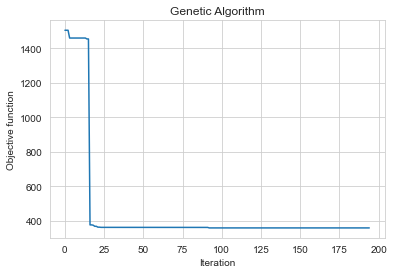

In [195]:
model.run()

This model is only built as a simple demonstration to show the concept. 

If you are going to use:
* Leadtime could be a normally distributed, rather than linearlh
* You could run this, iteratively on all parts based on actual [usage rather](https://github.com/joshuamschultz/business-analysis/blob/master/Inventory%20Optimization%20-%20Modeling%20Inventory%20Usage.ipynb) than described model
* Use better distributions (part pulls are not normally distributed)
* Use compound distributions (Poisson for timing, lognormal for quantity)
* Dont use average rounds (lose data), or find a way to capture the possible deviations lost in averaging
* Incorporate order costs, storage costs, and other costs
* Auto load historical data to generate the optimiziation
